
# **Deep Learning for Sentiment Analysis¶**

---


This notebook aims to provide an example of how a Recurrent Neural Network (RNN) using the Long Short Term Memory (LSTM) architecture can be implemented using Keras(https://keras.io/). Keras is a high-level neural networks API, written in Python and capable of running on top of TensorFlow, CNTK, or Theano. It was developed with a focus on enabling fast experimentation.

In this notebook, we have experimented with LSTM to perform sentiment analysis on movie reviews from the Large Movie Review Dataset(http://ai.stanford.edu/~amaas/data/sentiment/), better known as the IMDB dataset.

In this task, given a movie review, the model attempts to predict whether it is positive or negative. This is a binary classification task.

In [0]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence


## **Data¶**

As previously mentioned, we shall train a LSTM recurrent neural network on the Large Movie Review Dataset dataset.

The Large Movie Review Dataset (often referred to as the IMDB dataset) contains 25,000 highly-polar movie reviews (good or bad) for training and the same amount again for testing. The problem is to determine whether a given movie review has a positive or negative sentiment.

In [2]:
np.random.seed(7)
top_words=5000
(x_train, y_train), (x_test, y_test)=imdb.load_data(num_words=top_words)

17465344/17464789 [==============================] - 0s 0us/step



# **Word Embeddings¶**
The vocabulary of words in all the reviews is very large. Mere one-hot encoding of individual words will lead to an extremely sparse dataset.

Hence we will use Word Embeddings, a technique where words are encoded as real-valued vectors in a high dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space. This reduces sparsity of the data, as well as gives more meaning to each word in this embedded space, rather than just present or not.

In this notebook we won't have to use Gensim or create an embedding network from scratch. This is another advantage of using Keras. We just include another layer after the input in our model for generating embeddings of the input word! Keras provides a convenient way to convert positive integer representations of words into a word embedding by an Embedding layer.

We will map each word onto a 32 length real valued vector. We will also limit the total number of words that we are interested in modeling to the 5000 most frequent words, and zero out the rest. Finally, the sequence length (number of words) in each review varies, so we will constrain each review to be 500 words, truncating long reviews and pad the shorter reviews with zero values.

In [0]:
maxlength=500
x_train=sequence.pad_sequences(x_train,maxlen=maxlength)
x_test=sequence.pad_sequences(x_test,maxlen=maxlength)

# **LSTM and Convolutional Neural Network with dropout¶**

Convolutional neural networks (CNNs) generally excel at learning the spatial structure in input data. Hence they are widely used on data which comprise of highly correlated spatial structures. For example - Images! Images are unstructured data points, where groups of pixels represent a particular structure. Presence or absence of such structures, helps us classify images into particular category.

The IMDB review data does have a one-dimensional spatial structure in the sequence of words in reviews and the CNN may be able to pick out invariant features for good and bad sentiment. This learned spatial features may then be learned as sequences by an LSTM layer.

Adding a 1-D Convolutional layer followed by Max pooling is elementary in Keras.

Here we will add a 1-D Conv layer and max pooling layer after the Embedding layer which then feed the consolidated features to the LSTM. We use a set of 32 feature maps (convolutional filters) with a size of 3x3. The pooling layer can use the standard length of 2 to halve the feature map size.

In [4]:
embedding_vector_length=32
model=tf.keras.Sequential([
                           tf.keras.layers.Embedding(top_words,embedding_vector_length,input_length=maxlength),
                           tf.keras.layers.Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'),
                           tf.keras.layers.MaxPooling1D(pool_size=2),
                           tf.keras.layers.Dropout(0.2),
                           tf.keras.layers.LSTM(100,dropout=0.2,recurrent_dropout=0.2),
                           tf.keras.layers.Dense(1,activation='sigmoid')
                           
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 32)           160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 250, 32)           0         
_________________________________________________________________
dropout (Dropout)            (None, 250, 32)           0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 216,405
Trainable params: 216,405
Non-trainable params: 0
__________________________________________________

In [5]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=5,batch_size=32,validation_split=0.2)

Epoch 1/5
625/625 [==============================] - 246s 393ms/step - loss: 0.4255 - accuracy: 0.7905 - val_loss: 0.3226 - val_accuracy: 0.8628
Epoch 2/5
625/625 [==============================] - 245s 393ms/step - loss: 0.2553 - accuracy: 0.9009 - val_loss: 0.2793 - val_accuracy: 0.8850
Epoch 3/5
625/625 [==============================] - 245s 393ms/step - loss: 0.2093 - accuracy: 0.9199 - val_loss: 0.2833 - val_accuracy: 0.8828
Epoch 4/5
625/625 [==============================] - 246s 393ms/step - loss: 0.1729 - accuracy: 0.9377 - val_loss: 0.3095 - val_accuracy: 0.8800
Epoch 5/5
625/625 [==============================] - 246s 393ms/step - loss: 0.1534 - accuracy: 0.9436 - val_loss: 0.3497 - val_accuracy: 0.8782


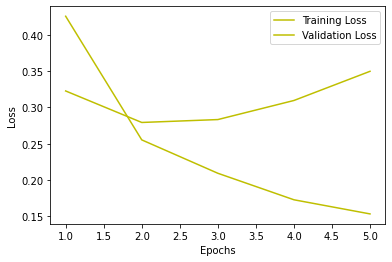

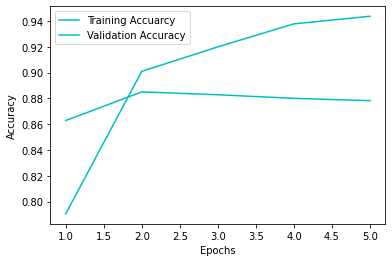

In [6]:
acc=history.history['accuracy']
loss=history.history['loss']
val_acc=history.history['val_accuracy']
val_loss=history.history['val_loss']

import matplotlib.pyplot as plt
epochs = range(1, 6)

plt.plot(epochs, loss, 'y', label = 'Training Loss')
plt.plot(epochs, val_loss, 'y', label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'c', label = 'Training Accuarcy')
plt.plot(epochs, val_acc, 'c', label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [7]:
scores = model.evaluate(x_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 87.25%
